# Check mining polygons

In [1]:
import geopandas as gpd
import shapely
import leafmap.foliumap as leafmap
import rasterio
from shapely.geometry import box

# # optional change working directiory first
import os
print(os.getcwd())
os.chdir("..")
print(os.getcwd())


import sys
sys.path.append('..')

from src.data.get_satellite_images import ReadSTAC

/workspaces/mine-segmentation/notebooks
/workspaces/mine-segmentation


In [2]:
# download mining polygons
import os
parend_dir = os.path.dirname(os.getcwd())
script_path = os.path.join(parend_dir, 'src', 'data', 'get_mining_polygons.py')
os.system(f'python {script_path}')

python: can't open file '/workspaces/src/data/get_mining_polygons.py': [Errno 2] No such file or directory


512

In [2]:
MAUS_POLYGONS = "data/external/maus_mining_polygons.gpkg"
MAUS_AREA_RASTER = "data/external/maus_mining_raster.tif"
TANG_POLYGONS = "data/external/tang_mining_polygons/74548_mine_polygons/74548_projected.shp"

# filter both dataframes to only the area of interest
LOCATION = [-50.16556135114535, -6.060451692157381]
BBOX = [LOCATION[0] - 0.5, LOCATION[1] - 0.5, LOCATION[0] + 0.5, LOCATION[1] + 0.5]


In [3]:
# Load a GeoPackage file into a GeoDataFrame
maus_gdf = gpd.read_file(MAUS_POLYGONS)

# Load a Shapefile into a GeoDataFrame
tang_gdf = gpd.read_file(TANG_POLYGONS)

In [6]:
maus_gdf.head()

,ISO3_CODE,COUNTRY_NAME,AREA,geometry
0,GBR,United Kingdom,1.782044,"POLYGON ((-1.67130 55.07660, -1.67040 55.07710..."
1,FJI,Fiji,0.023405,"POLYGON ((177.85480 -17.51730, 177.85490 -17.5..."
2,NZL,New Zealand,0.042758,"POLYGON ((175.87200 -37.34490, 175.87180 -37.3..."
3,FJI,Fiji,0.248552,"POLYGON ((177.84260 -17.51850, 177.84370 -17.5..."
4,FJI,Fiji,0.132724,"POLYGON ((177.84950 -17.49510, 177.84920 -17.4..."


In [7]:
tang_gdf.head()

,OBJECTID,Name,Shape_Le_1,Shape_Area,geometry
0,1,Au,507.731122,1.213696e+04,"POLYGON Z ((9746741.997 3480087.392 0.000, 974..."
1,2,Au,22248.346547,6.566996e+06,"POLYGON Z ((10362412.948 5571579.856 0.000, 10..."
2,3,Au,19467.203319,7.109258e+06,"POLYGON Z ((-6976558.709 -1779192.275 0.000, -..."
3,4,Fe,8281.186849,2.323061e+06,"POLYGON Z ((11034240.023 5539946.449 0.000, 11..."
4,5,0,1492.049584,1.231474e+05,"POLYGON Z ((8889342.751 3577269.676 0.000, 888..."


In [8]:
print(maus_gdf.shape)
print(tang_gdf.shape)

(44929, 4)
(74548, 5)


In [4]:
# check how many empty geometries are in the tang_gdf
empty_geometries = tang_gdf[tang_gdf.geometry == None]
len(empty_geometries)

0

In [5]:
# convert projected coordinates in tang to lat long
tang_gdf = tang_gdf.to_crs(epsg=4326)

In [6]:
# Flatten polygon dimensions from 3D to 2D
tang_gdf.geometry = shapely.wkb.loads(shapely.wkb.dumps(tang_gdf.geometry, output_dimension=2))

In [19]:
maus_gdf_filtered = maus_gdf.cx[BBOX[0]:BBOX[2], BBOX[1]:BBOX[3]]
tang_gdf_filtered = tang_gdf.cx[BBOX[0]:BBOX[2], BBOX[1]:BBOX[3]]

In [26]:
maus_gdf_filtered.iloc[0,:].geometry.bounds

(-50.342299999999994, -6.4754000000000005, -50.3121, -6.440400000000001)

In [12]:
maus_gdf_filtered.head()

,ISO3_CODE,COUNTRY_NAME,AREA,geometry
4308,BRA,Brazil,4.526153,"POLYGON ((-50.34230 -6.46640, -50.33970 -6.470..."
4316,BRA,Brazil,4.029746,"POLYGON ((-50.23900 -6.43630, -50.24980 -6.441..."
4329,BRA,Brazil,0.363408,"POLYGON ((-49.87660 -6.20440, -49.87830 -6.208..."
4334,BRA,Brazil,1.585674,"POLYGON ((-50.00340 -6.11420, -50.00800 -6.115..."
4339,BRA,Brazil,0.826450,"POLYGON ((-49.75480 -6.23760, -49.75770 -6.242..."


In [13]:
tang_gdf_filtered.head()

,OBJECTID,Name,Shape_Le_1,Shape_Area,geometry
7687,7688,Placemark,6284.211434,1.395161e+06,"POLYGON ((-50.58005 -6.05403, -50.58030 -6.051..."
7688,7689,Placemark,11521.144792,2.317360e+06,"POLYGON ((-50.57555 -6.02529, -50.57362 -6.025..."
7689,7690,Placemark,17145.217793,8.213193e+06,"POLYGON ((-50.53541 -5.78219, -50.53166 -5.782..."
7690,7691,Placemark,26207.278720,4.201798e+06,"POLYGON ((-50.51591 -5.76025, -50.51560 -5.760..."
7692,7693,Placemark,10317.859600,1.552590e+06,"POLYGON ((-50.30800 -6.10007, -50.30730 -6.100..."


In [ ]:
# Create a Leaflet map
m = leafmap.Map(center = [LOCATION[1], LOCATION[0]], zoom=10)
m.add_basemap("satellite")


style = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
    "fillOpacity": 0.1,
}

# Add the GeoDataFrame to the map
m.add_gdf(maus_gdf_filtered, layer_name="maus_gdf")
m.add_gdf(tang_gdf_filtered, layer_name="tang_gdf", style=style)

# Display the map
m

# Overlay a Sentinel Image with the mining polygons

In [15]:
# Download the image 
# Option 1 (Default): Read from Planetary Computer STAC API
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02']
bands_landsat = ['red', 'green', 'blue']

stac_reader = ReadSTAC(api_url=api_url, collection = "sentinel-2-l2a")

# check available items
items = stac_reader.get_items(
    location = LOCATION,
    buffer=10,
    timerange='2020-01-01/2020-12-30',
    max_cloud_cover=10
)

28 Items found.


## Start with only displaying a small Area of Interest

In [16]:
stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands, resolution=10)
stack_stretched = stac_reader.stretch_contrast_stack(stack, upper_percentile=1.0, lower_percentile=0.0)
image = stac_reader.save_stack_as_geotiff(stack_stretched, filename="sentinel_image.tif")

Loading stack...
Found 2 unique tile ids.
Choosing the best 1 items.For unique tile 22MFU, choosing ['S2B_MSIL2A_20200729T134219_R124_T22MFU_20200818T015550'] from [datetime.date(2020, 7, 29)] with [0.016453]% cloud cover
Choosing the best 1 items.For unique tile 22MEU, choosing ['S2A_MSIL2A_20200614T134221_R124_T22MEU_20200827T082613'] from [datetime.date(2020, 6, 14)] with [0.008988]% cloud cover
Stretching contrast...
Saving stack as GeoTIFF under: data/interim/sentinel_image.tif


In [ ]:
m = leafmap.Map(center = [LOCATION[1], LOCATION[0]], zoom=10)

m.add_raster(image, layer_name="Image")
m

In [ ]:
# add the polygons in the area
m.add_gdf(maus_gdf_filtered, layer_name="maus_gdf")
m.add_gdf(tang_gdf_filtered, layer_name="tang_gdf", style=style)
m

## Display the whole S2 Tile

In [19]:
least_cloudy_item = stac_reader.filter_item(items, filter_by="least_cloudy")

Found 2 unique tile ids.
Choosing the best 1 items.For unique tile 22MFU, choosing ['S2B_MSIL2A_20200729T134219_R124_T22MFU_20200818T015550'] from [datetime.date(2020, 7, 29)] with [0.016453]% cloud cover
Choosing the best 1 items.For unique tile 22MEU, choosing ['S2A_MSIL2A_20200614T134221_R124_T22MEU_20200827T082613'] from [datetime.date(2020, 6, 14)] with [0.008988]% cloud cover


In [ ]:
m = stac_reader.preview_tile_outlines(least_cloudy_item)
m

# Load Raster for mining areas from Maus et al

In [ ]:
# Load the raster for mining areas 
m = leafmap.Map(center = [LOCATION[1], LOCATION[0]], zoom=10)
m.add_raster(MAUS_AREA_RASTER, layer_name="Mining Areas", alpha=0.5)

# Display the map
m

In [24]:
import rasterio
img = rasterio.open(MAUS_AREA_RASTER)
img

<open DatasetReader name='data/external/maus_mining_raster.tif' mode='r'>

In [25]:

# Load the GeoTIFF file
with rasterio.open(MAUS_AREA_RASTER) as src:
    for ji, window in src.block_windows(1):
        # Get the geographic coordinates of the pixel
        left, bottom, right, top = src.window_bounds(window)
        print(f"Window bounds: {left, bottom, right, top}")
        # Read the data in the window
        data = src.read(window=window)
        print(f"Data shape: {data.shape}")

        break


Window bounds: (-180.0, 89.91666666666667, 180.0, 90.0)
Data shape: (1, 1, 4320)


In [26]:
src = rasterio.open(MAUS_AREA_RASTER)
array = src.read(1)
print(array.shape)
array

(2160, 4320)


array([[-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38],
       ...,
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-3.4e+38, -3.4e+38, -3.4e+38, ..., -3.4e+38, -3.4e+38, -3.4e+38]],
      dtype=float32)

In [27]:
# set all values less than 0 to 0 
array[array < 0] = 0
array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

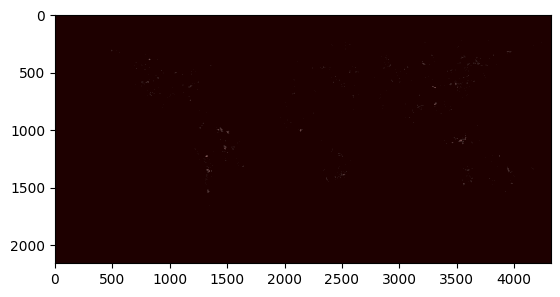

In [28]:
from matplotlib import pyplot
pyplot.imshow(array, cmap='pink')
pyplot.show()

In [29]:
src.transform

Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)

In [30]:
import numpy as np
from tqdm import tqdm
src = rasterio.open(MAUS_AREA_RASTER)
array = src.read(1)

# Get the transformation matrix
transform = src.transform

# Create an empty list to store the bounding boxes
bounding_boxes = []
mining_area = []

# Iterate over the pixels in the raster
# only record bounding box if they have over 0.5 square km of mining area (out of a total area per square of 78.41 sq.km)
for x in tqdm(range(src.width)):
    for y in range(src.height):
        if array[y, x] > 0.5:
            # Get the pixel's bounding box
            # The bounding box is defined by the pixel's top-left and bottom-right corners
            top_left = transform * (x, y)
            bottom_right = transform * (x + 1, y + 1)
            bounding_box = [top_left[0], bottom_right[1], bottom_right[0], top_left[1]]
            
            # Add the bounding box to the list
            bounding_boxes.append(bounding_box)

            # add the mining area to the list
            mining_area.append(array[y, x])


100%|██████████| 4320/4320 [00:08<00:00, 539.65it/s]


In [31]:
len(bounding_boxes)

17237

In [32]:
# Create a GeoDataFrame from the bounding boxes and the area
gdf = gpd.GeoDataFrame(geometry=[box(*bbox) for bbox in bounding_boxes], crs="EPSG:4326")
gdf["mining_area"] = mining_area
gdf

,geometry,mining_area
0,"POLYGON ((-165.41667 64.58333, -165.41667 64.6...",2.249622
1,"POLYGON ((-165.41667 64.50000, -165.41667 64.5...",2.141823
2,"POLYGON ((-165.33333 64.50000, -165.33333 64.5...",7.332864
3,"POLYGON ((-162.83333 68.00000, -162.83333 68.0...",7.319017
4,"POLYGON ((-162.75000 68.00000, -162.75000 68.0...",2.113401
...,...,...
17232,"POLYGON ((177.75000 64.66667, 177.75000 64.750...",1.631730
17233,"POLYGON ((177.91667 -17.58333, 177.91667 -17.5...",0.962196
17234,"POLYGON ((179.08333 -16.83333, 179.08333 -16.7...",1.399949
17235,"POLYGON ((179.25000 63.00000, 179.25000 63.083...",0.830650


In [ ]:

# Create a Map
m = leafmap.Map(center=[(bounding_boxes[0][1] + bounding_boxes[0][3]) / 2, 
                        (bounding_boxes[0][0] + bounding_boxes[0][2]) / 2], zoom=2)

# Add the GeoDataFrame to the map
m.add_gdf(gdf.iloc[0:100,:], layer_name="bounding_boxes")

# Display the map
m

In [34]:
# save the bounding boxes as a geopackage file
gdf.to_file("/workspaces/mine-segmentation/data/interim/mining_areas.gpkg", driver="GPKG")

# Sample random mining tile, plot 2019 sentinel image, and add both mining datasets to it. 

In [7]:
# read gdf
gdf = gpd.read_file("/workspaces/mine-segmentation/data/interim/mining_areas.gpkg")

In [8]:
import random

# Set the random seed for reproducibility
random.seed(1234)

In [9]:

YEAR = 2019

# Sample a random mining tile
random_tile = gdf.sample(n=1, random_state=random.randint(0, 100))

# Get the geometry of the random tile
tile_geometry = random_tile['geometry'].values[0]

bbox = tile_geometry.bounds

api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02']

stac_reader = ReadSTAC(api_url=api_url, collection = "sentinel-2-l2a")

# get the least cloudy sentinel image for the tile
items = stac_reader.get_items(
    bbox=bbox,
    timerange=f'{YEAR}-01-01/{YEAR}-12-31',
    max_cloud_cover=10
)

stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands, resolution=10)
stack_stretched = stac_reader.stretch_contrast_stack(stack, upper_percentile=0.99, lower_percentile=0.01)
image = stac_reader.save_stack_as_geotiff(stack_stretched, filename="sentinel_image.tif")

# Create a Map
m = leafmap.Map(center=[tile_geometry.centroid.y, tile_geometry.centroid.x], zoom=2)

# add the image
m.add_raster(image)

# Filter the polygons that are included 
maus_gdf_filtered = maus_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
tang_gdf_filtered = tang_gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

style = {
    "stroke": True,
    "color": "red",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "red",
    "fillOpacity": 0.1,
}

# Display the filtered gdfs
if not maus_gdf_filtered.empty:
    m.add_gdf(maus_gdf_filtered, layer_name="maus_gdf")

if not tang_gdf_filtered.empty:
    m.add_gdf(tang_gdf_filtered, layer_name="tang_gdf", style=style)

m

4 Items found.
Loading stack...
Found 1 unique tile ids.
Choosing the best 1 items.For unique tile 48RXR, choosing ['S2A_MSIL2A_20190812T032541_R018_T48RXR_20201004T232107'] from [datetime.date(2019, 8, 12)] with [0.405742]% cloud cover


UnboundLocalError: cannot access local variable 'stack' where it is not associated with a value

In [11]:
stack

NameError: name 'stack' is not defined